In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os
'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()

%matplotlib inline
'''Data Prep'''
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

''''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
import lightgbm as lgb

# Acquire Data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)
# โค้ดส่วนนี้กำลังเตรียมเครื่องมือสำหรับการวิเคราะห์ข้อมูลและสร้างโมเดลการเรียนรู้ของเครื่องเพื่อจำแนกประเภท โดยน่าจะมุ่งเน้นไปที่ข้อมูลบัตรเครดิตในไฟล์ CSV ที่นำเข้า

In [2]:
# Explore Data
data.shape
data.head()
data.describe()
data.columns
print("Number of fraudulent transactions:", data['Class'].sum())
nanCounter = np.isnan(data).sum()
nanCounter
distinctCounter = data.apply(lambda x: len(x.unique()))
distinctCounter
#โค้ดส่วนนี้กำลังสำรวจข้อมูลพื้นฐานของตารางข้อมูล "data" เพื่อดูภาพรวมของข้อมูล ลักษณะของข้อมูล และความผิดปกติต่างๆ เช่น Missing Value

Number of fraudulent transactions: 245.0


Time       52633
V1        115582
V2        115582
V3        115582
V4        115582
V5        115582
V6        115582
V7        115582
V8        115582
V9        115582
V10       115582
V11       115582
V12       115582
V13       115582
V14       115582
V15       115582
V16       115582
V17       115582
V18       115582
V19       115582
V20       115582
V21       115582
V22       115582
V23       115582
V24       115582
V25       115582
V26       115582
V27       115582
V28       115582
Amount     21383
Class          3
dtype: int64

In [3]:
# Generate feature matrix and labels array
data = data.dropna()

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()
dataX.describe()



#ส่วนนี้แยกข้อมูลออกเป็นเมทริกซ์คุณสมบัติ (เก็บตัวแปรต้น) และอาเรย์ป้ายกำกับ (เก็บตัวแปรตาม) เพื่อเตรียมพร้อมสำหรับการสร้างและฝึกโมเดลการเรียนรู้ของเครื่อง

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,...,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000,118800.000000
mean,46998.436978,-0.253710,-0.010574,0.679159,0.154892,-0.283747,0.090202,-0.115024,0.060153,-0.075804,...,0.043269,-0.035027,-0.113088,-0.035687,0.011257,0.131198,0.027270,0.000758,0.001908,94.493573
std,18875.311238,1.838585,1.636361,1.294602,1.336308,1.332112,1.292805,1.192510,1.226251,1.096853,...,0.741029,0.732461,0.637880,0.613765,0.594923,0.439151,0.491115,0.395394,0.317947,256.309780
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,...,-21.024817,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-22.565679,-11.710896,0.000000
25%,35590.000000,-1.021551,-0.585629,0.174841,-0.705751,-0.904425,-0.652701,-0.602611,-0.133708,-0.706103,...,-0.168259,-0.225348,-0.540868,-0.174438,-0.324316,-0.133662,-0.323164,-0.060809,-0.004592,6.900000
50%,48819.500000,-0.263312,0.088080,0.753946,0.182479,-0.316366,-0.162627,-0.067201,0.077902,-0.138369,...,-0.024930,-0.058589,-0.091301,-0.047907,0.067485,0.168343,-0.064534,0.010847,0.023442,25.000000
75%,62427.250000,1.155678,0.753718,1.375201,1.014340,0.242261,0.480951,0.411377,0.370281,0.509765,...,0.168268,0.117298,0.306572,0.082125,0.408417,0.419468,0.293182,0.084885,0.077160,85.000000
max,75217.000000,1.960497,18.902453,9.382558,16.715537,34.801666,22.529298,36.677268,20.007208,15.594995,...,39.420904,27.202839,10.503090,19.002942,4.016342,5.541598,3.517346,12.152401,33.847808,19656.530000


In [4]:
correlationMatrix = pd.DataFrame(data=[],index=dataX.columns,columns=dataX.columns)
for i in dataX.columns:
    for j in dataX.columns:
        correlationMatrix.loc[i,j] = np.round(pearsonr(dataX.loc[:,i],dataX.loc[:,j])[0],2)
correlation_file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'correlationMatrix.csv'])
correlationMatrix.to_csv(current_path+correlation_file)
#ส่วนนี้สร้างเมทริกซ์สหสัมพันธ์เพื่อดูความสัมพันธ์ระหว่างตัวแปรต้นแต่ละคู่ในข้อมูล 
#ช่วยให้เข้าใจลักษณะความสัมพันธ์ระหว่างตัวแปรและอาจใช้เป็นข้อมูลประกอบในการตัดสินใจเลือกหรือปรับแต่งฟีเจอร์ก่อนสร้างโมเดลต่อไป

/var/folders/cx/l3w70bss33bbtyjmzf3gmnp00000gp/T/ipykernel_7432/2094311258.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'],sort=True).sort_index()


Text(0, 0.5, 'Frequency Percentage')

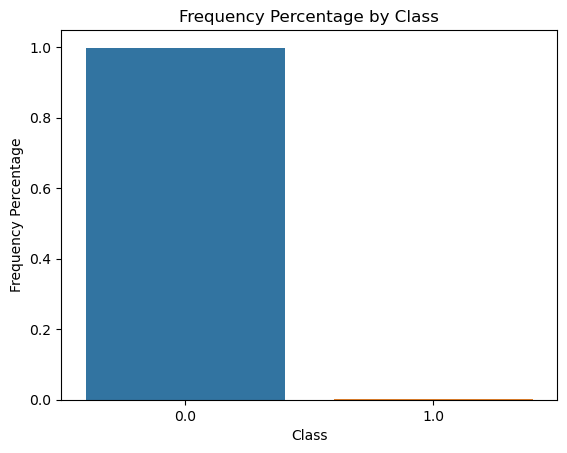

In [5]:
count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
ax = sns.barplot(x=count_classes.index,
y=[tuple(count_classes/len(data))[0],tuple(count_classes/len(data))[1]])
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')
# ส่วนนี้สร้างกราฟแท่งเพื่อแสดงการกระจายของข้อมูลในคลาสต่างๆ 
#ช่วยให้มองเห็นภาพได้ว่าข้อมูลมีสัดส่วนระหว่างคลาสมากน้อยเพียงใด 
#ซึ่งเป็นประโยชน์ในการพิจารณาความสมดุลของข้อมูล และอาจเป็นปัจจัยในการตัดสินใจเลือกเทคนิคการสร้างโมเดลที่เหมาะสม

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY, test_size=0.33,
random_state=2018, stratify=dataY)
#ส่วนนี้แบ่งข้อมูลออกเป็นชุดฝึกและชุดทดสอบ โดยกำหนดให้ชุดทดสอบมีสัดส่วนเท่ากับ 33% ของขนาดข้อมูลทั้งหมด 
#และชุดฝึกและชุดทดสอบมีสัดส่วนคลาสเท่ากัน ซึ่งจะช่วยให้โมเดลที่สร้างขึ้นมีความสมดุลและมีประสิทธิภาพในการจำแนกคลาสทั้ง 2 อย่างเท่าเทียมกัน

In [7]:
len(X_train)
len(X_test)
y_train.sum()/len(y_train)
y_test.sum()/len(y_test)
#ส่วนนี้ตรวจสอบขนาดของชุดฝึกและชุดทดสอบ และคำนวณสัดส่วนของธุรกรรมที่เป็นการฉ้อโกงในแต่ละชุด 
#เพื่อให้ทราบข้อมูลพื้นฐานของชุดข้อมูลที่ใช้สร้างโมเดล

0.002066115702479339

In [8]:
featuresToScale = dataX.drop(['Time'],axis=1).columns
featuresToScale
#featuresToScale จะถูกนำไปใช้สำหรับการปรับขนาดข้อมูล (Feature Scaling)
#เพื่อให้ข้อมูลมีมาตราส่วนเดียวกัน ซึ่งจะช่วยให้โมเดลการเรียนรู้ของเครื่องมีประสิทธิภาพมากขึ้น

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [9]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)
sX = pp.StandardScaler(copy=True)
X_train.loc[:,featuresToScale ] = sX.fit_transform(X_train.loc[:,featuresToScale])
scalingFactors = pd.DataFrame (data=[sX.mean_,sX.scale_],index=['Mean','StDev'],columns=featuresToScale)
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])
scalingFactors
#ส่วนนี้ทำการปรับขนาดข้อมูลด้วย StandardScaler เพื่อให้ตัวแปรต้นมีค่าเฉลี่ยเท่ากับ 0 และค่าเบี่ยงเบนมาตรฐานเท่ากับ 1 
#ซึ่งช่วยให้โมเดลการเรียนรู้ของเครื่องมีประสิทธิภาพมากขึ้นโดยเฉพาะเมื่อตัวแปรต้นมีมาตราส่วนที่แตกต่างกันมาก 
#การปรับขนาดข้อมูลทำทั้งกับชุดฝึกและชุดทดสอบโดยใช้ค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐานที่คำนวณจากชุดฝึกเท่านั้น

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,-0.251270,-0.009967,0.678485,0.159617,-0.284306,0.096022,-0.111551,0.058886,-0.073253,-0.015969,...,0.043786,-0.036091,-0.114004,-0.034564,0.010968,0.131616,0.026837,0.001395,0.002877,95.192650
StDev,1.841916,1.648216,1.293298,1.333184,1.335107,1.297488,1.191909,1.218729,1.096420,1.049301,...,0.748275,0.734332,0.640116,0.615192,0.595326,0.440348,0.490139,0.395289,0.326051,263.896726


In [10]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)
#ส่วนนี้กำหนดค่าให้กับตัวแบ่งข้อมูลแบบ K-Fold Cross Validation โดยกำหนดให้แบ่งข้อมูลออกเป็น 5 ส่วน โดยการสุ่มข้อมูลก่อนแบ่ง 
#เพื่อใช้ในการประเมินประสิทธิภาพของโมเดลการเรียนรู้ของเครื่อง

In [11]:
penalty = 'l2'
C = 1.0
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
n_jobs = 1

logReg = LogisticRegression(penalty=penalty, C=C,
    class_weight=class_weight, random_state=random_state,
        solver=solver, n_jobs=n_jobs)
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                    index=y_train.index,columns=[0,1])
model = logReg

for train_index, cv_index in k_fold.split(np.zeros(len(X_train))
                        ,y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,
                    model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)

    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
      model.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold,
                predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)

    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train,
                    predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)
#ส่วนนี้สร้างโมเดล Logistic Regression และประเมินประสิทธิภาพด้วยเทคนิค K-Fold Cross Validation 
#เพื่อวัดผลลัพธ์ของโมเดลในภาพรวมที่ครอบคลุมข้อมูลทั้งหมด โดยลดอคติที่อาจเกิดขึ้นจากการแบ่งชุดข้อมูลแบบเฉพาะเจาะจง 
#ผลลัพธ์ที่ได้คือค่า log loss บนชุดฝึกและชุดทดสอบในแต่ละรอบของ cross-validation รวมทั้งค่า log loss ของโมเดลบนชุดฝึกทั้งหมด




Training Log Loss:  0.12271691125101784
CV Log Loss:  0.1218542385547903
Training Log Loss:  0.1029630884912655
CV Log Loss:  0.10364767595493585
Training Log Loss:  0.10527920107174318
CV Log Loss:  0.10513943085617697
Training Log Loss:  0.11234101485679167
CV Log Loss:  0.10976750869698751
Training Log Loss:  0.10228748851021398
CV Log Loss:  0.10395609108714084
Logistic Regression Log Loss:  0.10887315211922592


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.64')

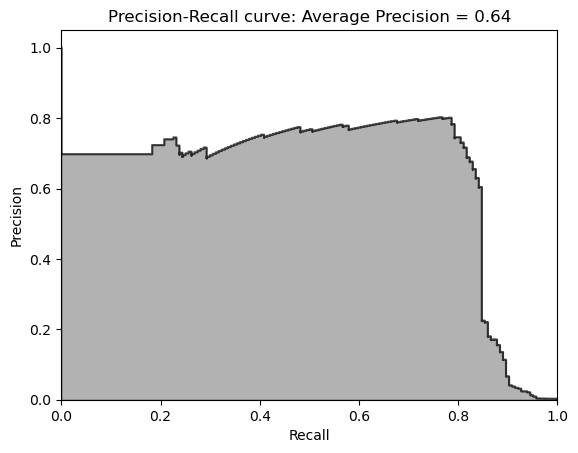

In [12]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
average_precision))
#

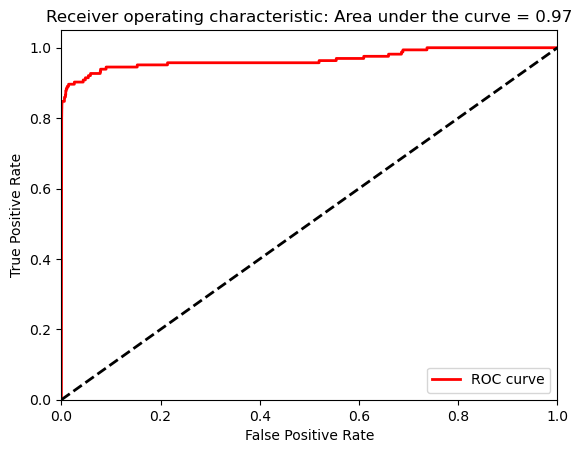

In [13]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()
#ส่วนนี้ประเมินประสิทธิภาพของโมเดล Logistic Regression โดยใช้กราฟ Precision-Recall Curve และค่า average precision 
#ซึ่งเหมาะสำหรับการวัดประสิทธิภาพของโมเดลในการจำแนกคลาสที่ไม่สมดุลกัน (เช่น ในกรณีนี้ที่มีสัดส่วนธุรกรรมฉ้อโกงน้อยมาก) 
#กราฟ Precision-Recall Curve จะแสดงความสัมพันธ์ระหว่าง precision (สัดส่วนของธุรกรรมที่โมเดลคาดการณ์ว่าเป็นฉ้อโกงซึ่งถูกต้องจริง) 
#และ recall (สัดส่วนของธุรกรรมฉ้อโกงทั้งหมดที่โมเดลสามารถตรวจจับได้)

In [14]:
from sklearn.ensemble import RandomForestClassifier
n_estimators = 10
max_features = 'log2'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 2018
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators,
    max_features=max_features, max_depth=max_depth,
    min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
    min_weight_fraction_leaf=min_weight_fraction_leaf,
    max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,
    oob_score=oob_score, n_jobs=n_jobs, random_state=random_state,
    class_weight=class_weight)

trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = RFC

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                    y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, \
                        model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
     model.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold, \
      predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)

loglossRandomForestsClassifier = log_loss(y_train,
                    predictionsBasedOnKFolds.loc[:,1])
print('Random Forests Log Loss: ', loglossRandomForestsClassifier)
#ส่วนนี้สร้างโมเดล Random Forest Classifier และประเมินประสิทธิภาพด้วยเทคนิค K-Fold Cross Validation 
#เช่นเดียวกับที่ทำกับโมเดล Logistic Regression เพื่อเปรียบเทียบประสิทธิภาพระหว่างโมเดลทั้งสองแบบ

Training Log Loss:  0.0004411451861741109
CV Log Loss:  0.009854377648379955
Training Log Loss:  0.000521240399319909
CV Log Loss:  0.007793818349963471
Training Log Loss:  0.00041027500005057227
CV Log Loss:  0.01668627412863618
Training Log Loss:  0.00044810117813915134
CV Log Loss:  0.012199500815104172
Training Log Loss:  0.0004225046545508635
CV Log Loss:  0.012196894287508841
Random Forests Log Loss:  0.011746149278450342


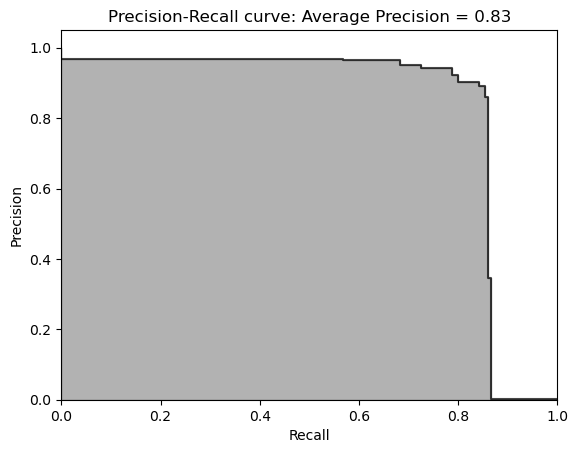

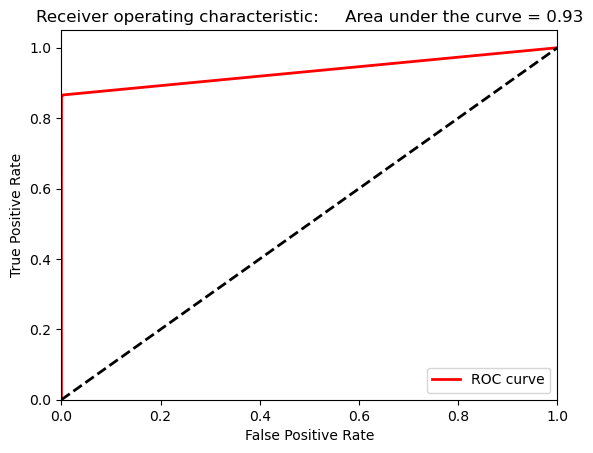

In [15]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsRandomForests = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                    preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
        average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(
    areaUnderROC))

plt.legend(loc="lower right")
plt.show()
#ส่วนนี้ประเมินประสิทธิภาพของโมเดล Random Forest Classifier โดยใช้ทั้งกราฟ Precision-Recall Curve และกราฟ ROC Curve 
#ซึ่งช่วยให้เห็นความสามารถของโมเดลในมุมที่แตกต่างกัน กราฟ Precision-Recall Curve 
#ให้ความสำคัญกับ precision และ recall โดยตรง ในขณะที่กราฟ ROC Curve
#ให้ภาพรวมของความสามารถในการแยกแยะระหว่างคลาสของโมเดลโดยพิจารณาจาก fpr และ tpr

In [16]:
params_lightGB = {
    'task': 'train',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': -1,
    'num_threads':16
}
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                    index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000, valid_sets=lgb_eval)
    
    loglossTraining = log_loss(y_train_fold, \
            gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration)
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
   
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)
#ส่วนนี้สร้างโมเดล LightGBM ซึ่งเป็นโมเดลแบบ Gradient Boosting และประเมินประสิทธิภาพด้วยเทคนิค K-Fold Cross Validation 
#เช่นเดียวกับโมเดลอื่นๆ เพื่อเปรียบเทียบประสิทธิภาพระหว่างโมเดลทั้งสามแบบในการจัดการกับปัญหาการจำแนกธุรกรรมฉ้อโกง

Training Log Loss:  6.9831872307049355e-06
CV Log Loss:  0.002190374670761919
Training Log Loss:  7.3938988424985774e-06
CV Log Loss:  0.0025619638765776095
Training Log Loss:  3.914903806354132e-06
CV Log Loss:  0.005885644104309518
Training Log Loss:  5.548970592492418e-06
CV Log Loss:  0.0043933005855482845
Training Log Loss:  3.0485171726178747e-06
CV Log Loss:  0.005274662972631916
LightGBM Gradient Boosting Log Loss:  0.004061165738089133


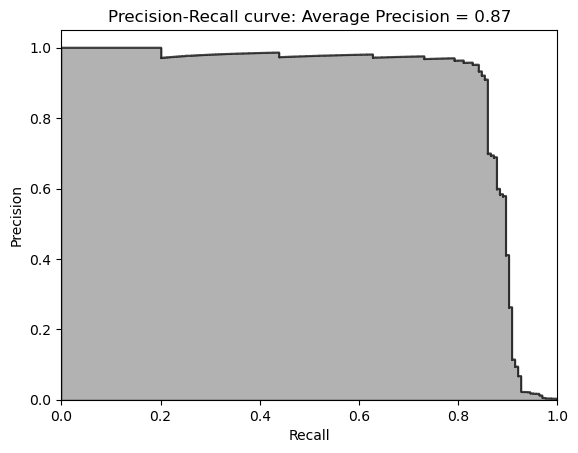

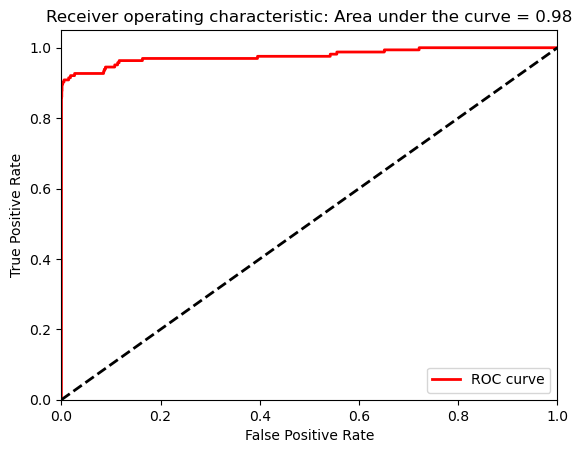

In [17]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()
precision, recall, thresholds = \
precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
average_precision_score(preds['trueLabel'],preds['prediction'])
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
average_precision))
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()
#ส่วนนี้ประเมินประสิทธิภาพของโมเดล LightGBM โดยใช้ทั้งกราฟ Precision-Recall Curve และกราฟ ROC Curve

In [19]:
predictionsTestSetLogisticRegression = \
pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = \
logReg.predict_proba(X_test)[:,1]
logLossTestSetLogisticRegression = \
log_loss(y_test, predictionsTestSetLogisticRegression)
predictionsTestSetRandomForests = \
pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForests.loc[:,'prediction'] = \
RFC.predict_proba(X_test)[:,1]
logLossTestSetRandomForests = \
log_loss(y_test, predictionsTestSetRandomForests)
predictionsTestSetLightGBMGradientBoosting = \
pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLightGBMGradientBoosting.loc[:,'prediction'] = \
gbm.predict(X_test, num_iteration=gbm.best_iteration)
logLossTestSetLightGBMGradientBoosting = \
log_loss(y_test, predictionsTestSetLightGBMGradientBoosting)
print("Log Loss of Logistic Regression on Test Set: ", \
logLossTestSetLogisticRegression)
print("Log Loss of Random Forests on Test Set: ", \
logLossTestSetRandomForests)
# print("Log Loss of XGBoost Gradient Boosting on Test Set: ", \
# logLossTestSetXGBoostGradientBoosting)
# print("Log Loss of LightGBM Gradient Boosting on Test Set: ", \
# logLossTestSetLightGBMGradientBooyuta2sting)
#ส่วนนี้ประเมินประสิทธิภาพของโมเดลทั้งสามแบบบนชุดทดสอบ โดยใช้ค่า log loss เป็นตัวชี้วัด โมเดลที่มีค่า log loss ต่ำกว่า ถือว่ามีประสิทธิภาพดีกว่า

Log Loss of Logistic Regression on Test Set:  0.10244247474930009
Log Loss of Random Forests on Test Set:  0.011305572686208729


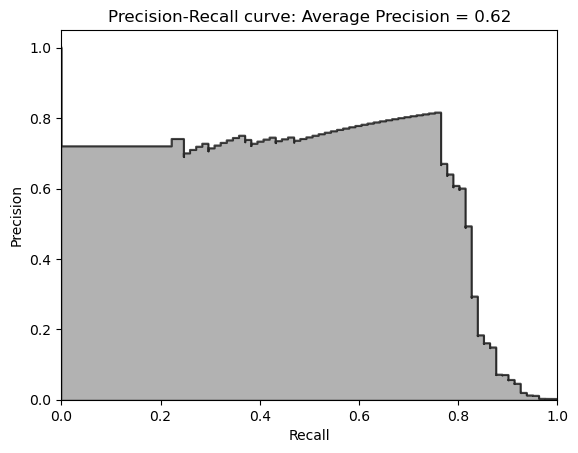

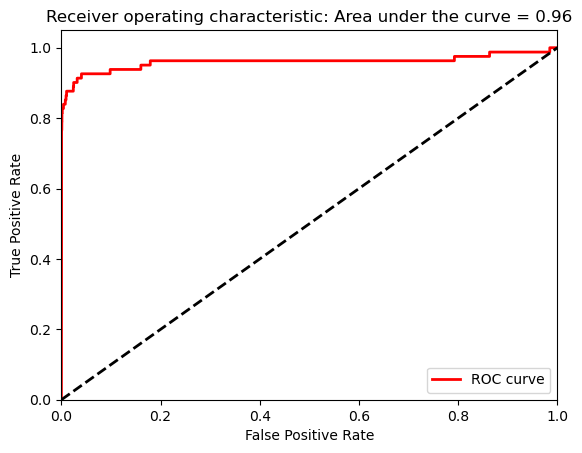

In [20]:
precision, recall, thresholds = \
precision_recall_curve(y_test,predictionsTestSetLogisticRegression)
average_precision = \
average_precision_score(y_test,predictionsTestSetLogisticRegression)
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
average_precision))
fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetLogisticRegression)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

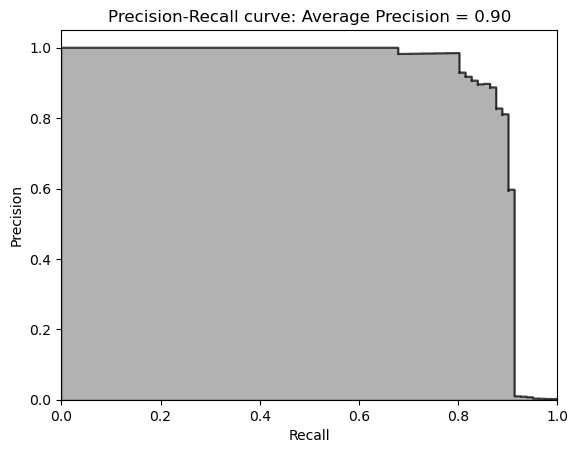

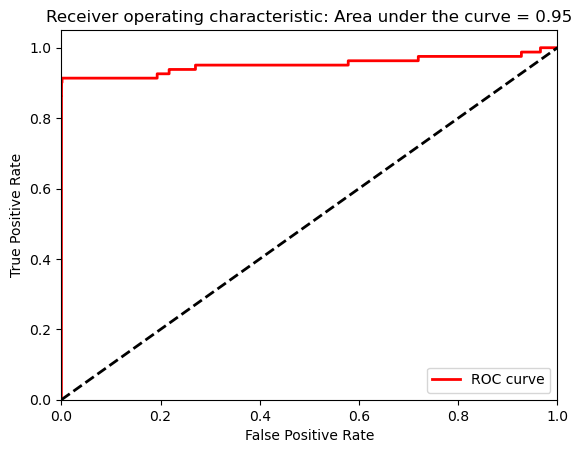

In [21]:
precision, recall, thresholds = \
precision_recall_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
average_precision = \
average_precision_score(y_test,predictionsTestSetLightGBMGradientBoosting)
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
average_precision))
fpr, tpr, thresholds = \
roc_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [ ]:
สรุป
โมเดล Logistic Regression และ Random Forest Classifier มีประสิทธิภาพใกล้เคียงกันโดยมีประสิทธิภาพโดยรวมดีที่สุด 
และสามารถแยกแยะระหว่างคลาสฉ้อโกงและคลาสปกติได้อย่างมีประสิทธิภาพ โดยค่า recall สูงและค่า precision สูงเช่นกัน 
โมเดล LightGBM Gradient Boosting มีประสิทธิภาพโดยรวมรองจากโมเดลทั้งสอง แต่ก็ยังมีประสิทธิภาพที่ดีในระดับหนึ่ง 
การเลือกโมเดลที่เหมาะสมสำหรับปัญหานั้นๆ ขึ้นอยู่กับปัจจัยต่างๆ เช่น ลักษณะของข้อมูล ข้อมูลที่ดี ที่มี และเป้าหมายที่ต้องการ